In [1]:
import numpy as np
import pandas as pd
import matplotlib
from scipy.spatial.distance import pdist
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
blobs = pd.read_csv('blobs.csv')
blobs.head()

,X,Y
0,-0.727696,1.403000
1,-1.875566,0.589247
2,-0.891047,-1.399924
3,-0.224115,0.868289
4,-0.465409,0.306718


In [2]:
def k_means_pp(ds, k):
    p1_idx = np.random.choice(range(ds.shape[0]), 1)[0]
    centers = [p1_idx] + [-1 for _ in range(k - 1)]
    
    for i in range(1, k):
        dists = [min([np.linalg.norm(x - ds[j]) ** 2 for j in centers[:i]]) for x in ds]
        summ = sum(dists)
        dists = [x / summ for x in dists]
        
        centers[i] = np.random.choice(range(ds.shape[0]), 1, p=dists)[0]
    return centers

In [3]:
def k_means(ds, k, eps=10**-3, show_dunn=True):
    clust_card = [0 for _ in range(k)]
    clust_sum = [[0 for _ in range(ds.shape[1])] for _ in range(k)]
     
    centers = k_means_pp(ds, k)
    for x in ds:
        idx = np.argmin([np.linalg.norm(x - ds[c]) for c in centers])
        clust_card[idx] += 1
        clust_sum[idx] += x
        
    prev_centers = [ds[c] for c in centers]
    centers = [clust_sum[i] / clust_card[i] for i in range(k)]
    
    while np.linalg.norm([prev_centers[i] - centers[i] for i in range(k)]) > eps:
        clust_card = [0 for _ in range(k)]
        clust_sum = [[0 for _ in range(ds.shape[1])] for _ in range(k)]
        
        for x in ds:
            idx = np.argmin([np.linalg.norm(x - c) for c in centers])
            clust_card[idx] += 1
            clust_sum[idx] += x
        
        prev_centers = centers
        centers = [clust_sum[i] / clust_card[i] for i in range(k)]
        
    clusters = [np.argmin([np.linalg.norm(x - c) for c in centers]) for x in ds]
    if show_dunn:
        print('k={}; Dunn index = {:.3f}'
              .format(k, dunn_index(ds, centers, clusters)))
    return clusters

In [5]:
def dunn_index(ds, centers, clusters):
    min_dist = np.inf
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            if np.linalg.norm(centers[i] - centers[j]) < min_dist:
                min_dist = np.linalg.norm(centers[i] - centers[j])
                
    max_dist = 0
    for i in range(ds.shape[0]):
        for j in range(i + 1, ds.shape[0]):
            if clusters[j] != -1 and clusters[j] == clusters[i] and np.linalg.norm(ds[i] - ds[j]) > max_dist:
                max_dist = np.linalg.norm(ds[i] - ds[j])
    
    return min_dist / max_dist

In [6]:
def plot_clusters(ds, labels, ks, algorithm):
    plt.figure(figsize=(10, 15))
    for i in range(len(ks)):
        plt.subplot(len(ks),1,i+1)
        plt.scatter(ds[:, 0], ds[:, 1], c=labels[i])
        plt.title('Результат работы алгоритма {} при числе кластеров={}'
                  .format(algorithm, ks[i]))
    plt.show()

# K-Means

In [7]:
blobs = blobs.values

k=2; Dunn index = 0.489
k=3; Dunn index = 0.616
k=4; Dunn index = 0.571
k=5; Dunn index = 0.355


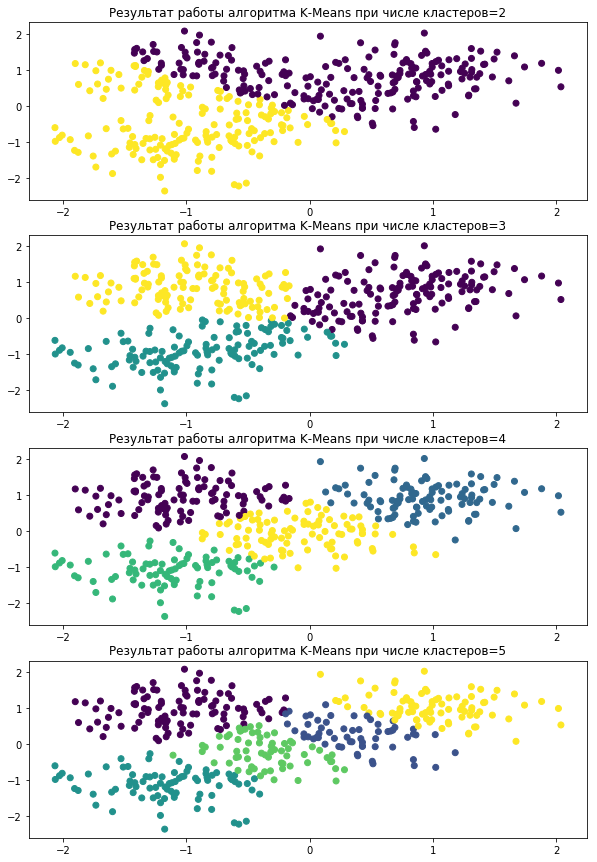

In [20]:
labels = []
for k in range(2, 6):
    labels.append(k_means(blobs, k))
plot_clusters(blobs, labels, range(2, 6), 'K-Means')

# DBSCAN

In [13]:
def square_to_condensed(i, j, n):
    if i < j:
        i, j = j, i
    return int(n*j - j*(j+1)/2 + i - 1 - j)

In [14]:
def find_neighbors(idx, dists, eps, core_samples, label, clusts, n):
    clusts[idx] = label
    for i in range(n):
        if i == idx or clusts[i] != -1 or dists[square_to_condensed(idx, i, n)] > eps:
            continue
        if i in core_samples:
            find_neighbors(i, dists, eps, core_samples, label, clusts, n)
        else:
            clusts[i] = label
    return clusts

In [15]:
def DBSCAN(ds, m, eps):
    core_samples = []
    dist_matrix = pdist(ds, 'euclidean')
    n = ds.shape[0]
    
    for i in range(n):
        n_neigh = 0
        for j in range(n):
            if j != i and dist_matrix[square_to_condensed(i, j, n)] < eps:
                n_neigh += 1
                if n_neigh == m:
                    core_samples.append(i)
                    break
    
    clusts = [-1 for _ in range(n)]
    curr_label = 0
    for i in core_samples:
        if clusts[i] == -1:
            clusts = find_neighbors(i, dist_matrix, eps, core_samples,
                                    curr_label, clusts, n)
            curr_label += 1
    
    return clusts

In [16]:
def find_params(ds, k):
    m = 10
    while True:
        for eps in np.linspace(0.2, 0.5, 10):
            clusts = DBSCAN(ds, m, eps)
            if len(np.unique(clusts)) - 1 == k:
                return m, eps, clusts
        m -= 1

In [17]:
def plot_dbscan(ds, labels):
    colors=['green', 'red', 'blue', 'yellow', 'purple']
    plt.scatter(ds[:, 0], ds[:, 1], c=labels, 
                cmap=matplotlib.colors.ListedColormap(colors))
    
    cb = plt.colorbar()
    loc = np.arange(-1,max(labels),max(labels)/float(len(colors)) + 0.3)
    cb.set_ticks(loc)
    cb.set_ticklabels(['outliers', 'cluster1', 'cluster2', 'cluster3', 'cluster4'])
    
    plt.show()

In [18]:
def get_centers(ds, labels):
    c_cards = [0 for _ in range(len(np.unique(labels)))]
    c_means = [np.zeros((1, 2)) for _ in range(len(np.unique(labels)))]
    if -1 in labels:
        c_cards.pop()
        c_means.pop()
    
    for i in range(ds.shape[0]):
        if labels[i] != -1:
            c_cards[labels[i]] += 1
            c_means[labels[i]] += ds[i]
        
        
    return [sum_ / card for sum_, card in zip(c_means, c_cards)]

Параметры алгоритма DBSCAN для получения 4х кластеров: m=8, eps=0.23333333333333334
Dunn index: 0.771


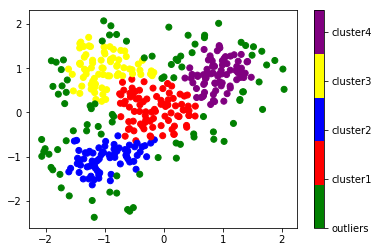

In [21]:
m, eps, clusters = find_params(blobs, 4)
print('Параметры алгоритма DBSCAN для получения 4х кластеров: m={}, eps={}'.format(m, eps))
print('Dunn index: {:.3f}'
      .format(dunn_index(blobs, get_centers(blobs, clusters), clusters)))
plot_dbscan(blobs, clusters)

# Agglomerative Clustering

In [49]:
def agglomerative_clustering(ds, ks):
    clusters = [[i] for i in range(ds.shape[0])]
    res = {}
    
    def __dist(x, y):
        max_ = 0
        for i in clusters[x]:
            for j in clusters[y]:
                if np.linalg.norm(ds[i] - ds[j]) > max_:
                    max_ = np.linalg.norm(ds[i] - ds[j])
        return max_
    
    for _ in range(ds.shape[0] - 1):
        min_dists = 100
        c1, c2 = -1, -1
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                d = __dist(i, j)
                if d < min_dists:
                    min_dists = d
                    c1, c2 = i, j
        
        for c in clusters[c2]:
            clusters[c1].append(c)
        clusters.remove(clusters[c2])
        
        if len(clusters) in ks:
            labels = [-1 for _ in range(ds.shape[0])]
            for i in range(len(clusters)):
                for c in clusters[i]:
                    labels[c] = i
            res[len(clusters)] = labels
    return res

In [50]:
clusts = agglomerative_clustering(blobs, range(2, 6))

In [51]:
for i in range(2, 6):
    print('k={}; Dunn index={:.3f}'
          .format(i, dunn_index(blobs, get_centers(blobs, clusts[i]), clusts[i])))

k=2; Dunn index=0.508
k=3; Dunn index=0.495
k=4; Dunn index=0.552
k=5; Dunn index=0.366


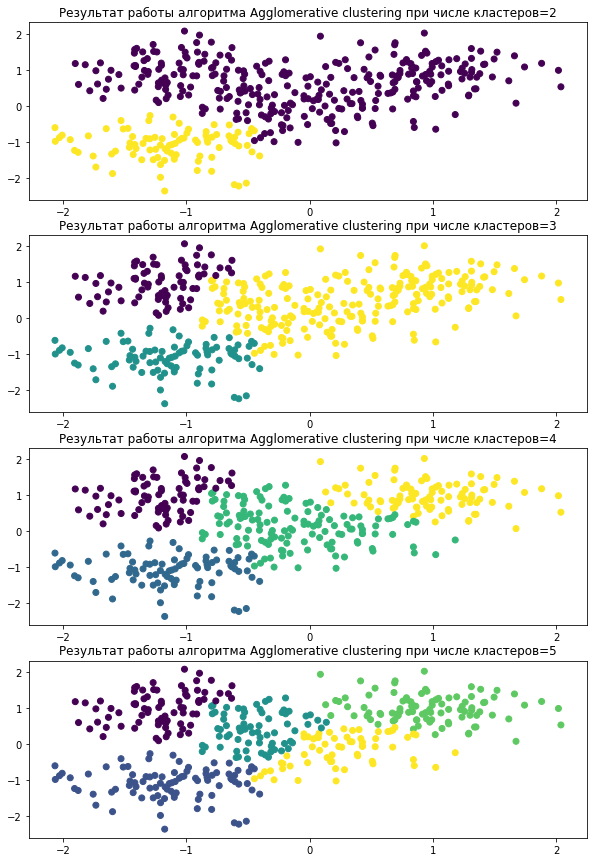

In [52]:
plot_clusters(algorithm='Agglomerative clustering', ds=blobs, 
              ks=range(2, 6), labels=[clusts[i] for i in range(2, 6)])

# k-MEANS; cancer dataset

In [4]:
cancer = pd.read_csv('../HW1/cancer.csv')

In [5]:
labels = cancer.label.values
cancer = cancer.loc[:, '1':'30'].values

In [6]:
cancer_clusters = []
for k in range(2, 11):
    cancer_clusters.append(k_means(cancer, k, show_dunn=False))

In [7]:
def purity(ds, labels, clusters):
    n_class = [[0, 0] for _ in range(len(np.unique(clusters)))]
    clust_card = [0 for _ in range(len(np.unique(clusters)))]
    
    for i in range(ds.shape[0]):
        clust_card[clusters[i]] += 1
        if labels[i] == 'M':
            n_class[clusters[i]][0] += 1
        else:
            n_class[clusters[i]][1] += 1
    
    return sum([max(c) for c in n_class]) / sum(clust_card)

In [8]:
for k in range(2, 11):
    print('Метрика purity при k={}: {:.3f}'
          .format(k, purity(cancer, labels, cancer_clusters[k - 2])))

Метрика purity при k=2: 0.854
Метрика purity при k=3: 0.866
Метрика purity при k=4: 0.882
Метрика purity при k=5: 0.884
Метрика purity при k=6: 0.877
Метрика purity при k=7: 0.888
Метрика purity при k=8: 0.889
Метрика purity при k=9: 0.909
Метрика purity при k=10: 0.907


# K_MEANS; scaled cancer dataset

In [9]:
cancer_scaled = MinMaxScaler().fit_transform(cancer)
cancer_scaled_clusters = []
for k in range(2, 11):
    cancer_scaled_clusters.append(k_means(cancer_scaled, k, show_dunn=False))

In [10]:
for k in range(2, 11):
    print('Метрика purity при k={}: {:.3f}'
          .format(k, purity(cancer_scaled, labels, cancer_scaled_clusters[k - 2])))

Метрика purity при k=2: 0.928
Метрика purity при k=3: 0.903
Метрика purity при k=4: 0.877
Метрика purity при k=5: 0.930
Метрика purity при k=6: 0.928
Метрика purity при k=7: 0.910
Метрика purity при k=8: 0.930
Метрика purity при k=9: 0.949
Метрика purity при k=10: 0.940
